# Get RSI, MFI Indicators with FDR
-  An increasing RSI represents bullishness in a stock, while a decreasing RSI appears to push the prices down.
- The RSI values are categorized in Low, Medium and High category. 
- When RSI is in medium range, the price movement is most favourable. RSI in higher range is sometimes an indication of impending correction.

In [8]:
!pip install finance-datareader
!pip install plotly

     |████████████████████████████████| 16.4 MB 5.7 MB/s            


In [69]:
import FinanceDataReader as fdr

In [130]:
Ticker = "005930"

df = fdr.DataReader(Ticker, start='2019-01-01', end='2024-05-15')
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2019-01-02,39400,39400,38550,38750,7847664,0.00
2019-01-03,38300,38550,37450,37600,12471493,-0.03
2019-01-04,37450,37600,36850,37450,14108958,-0.00
2019-01-07,38000,38900,37800,38750,12748997,0.03
2019-01-08,38000,39200,37950,38100,12756554,-0.02


In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

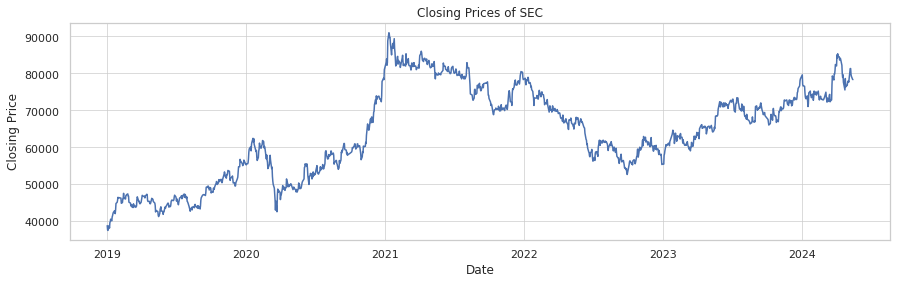

In [132]:
# Assuming 'Close' is the column containing closing prices in df
plt.plot(df.index, df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Prices of SEC')
plt.show()

# RSI (Relative Strength Index)
- 상대강도지수란 일정 기간동안의 상승폭과 하락폭에대한 상대비율을 시장의 과매수 혹은 과매도로 표현한 지표입니다.
- 즉, 현재의 시장이 강한 매수세인지 강한 매도세인지를 비율로 확인할 수 있습니다.
- 기본적으로 14일간의 데이터를 사용합니다.
- 보통 50 미만(LOW)일 때는 매입하지 않고, 그 이상인 경우가 매수세이므로 주가 상승기라고 판단합니다.

In [133]:
import numpy as np
import pandas as pd

def get_rsi(df, period = 14):
    df["Close"] = df["Close"]
    delta = df["Close"].diff() # 종가의 차이를 계산
    up, down = delta.copy(), delta.copy() # 상승분과 하락분을 따로 계산하기 위해 복사
    up[up < 0] = 0 # 상승분, U
    down[down > 0] = 0 # 하락분, D
    _gain = up.ewm(com=(period - 1), min_periods=period).mean() # AU(U값의 평균)
    _loss = down.abs().ewm(com=(period - 1), min_periods=period).mean() # DU(D값의 평균)
    RS = _gain / _loss
    rsi_14 = pd.Series(100 - (100 / (1 + RS)), name="RSI")
    df['RSI'] = rsi_14
    return df
    
    
get_rsi(df).tail(20)

,Open,High,Low,Close,Volume,Change,RSI
Date,,,,,,,
2024-04-15,82900,83200,81200,82200,26663772,-0.02,57.90
2024-04-16,81200,81300,79400,80000,31949845,-0.03,49.29
2024-04-17,80700,80800,78900,78900,22611631,-0.01,45.64
2024-04-18,78800,80100,78300,79600,21370190,0.01,48.27
2024-04-19,78300,78700,76300,77600,31317563,-0.03,42.02
2024-04-22,77400,77500,75100,76100,30469477,-0.02,38.04
2024-04-23,76400,76800,75500,75500,18717699,-0.01,36.55
2024-04-24,77500,78800,77200,78600,22166150,0.04,47.91
2024-04-25,77300,77500,76300,76300,15549134,-0.03,41.91


# MFI (Money Flow Index)
- 주가와 거래량을 고려해 시장이 과열상태인지 여부를 알려주는 지표이다.
- MFI가 20선을 상향돌파하면 매수, 80선을 하향돌파하면 매도하는 전략을 사용할 수 있다
- RSI와 비슷한 지표이지만 주식의 가격 뿐만 아니라 거래량도 함께 사용한다는 차이가 있으며, ‘거래량을 감안한 RSI’로도 알려져 있다. 
- MFI는 0에서 100 사이의 범위에서 움직이는 오실레이터로, 그 값이 20 이하일 때는 과매도, 80 이상일때는 과매수 상태로 판단할 수 있다.
- MFI 지수가 80을 돌파하면 상승 추세의 강세 신호로 간주되고, 20을 하회하면 하락 추세의 강세 신호로 간주됩니다

In [134]:
def get_mfi(df, period = 14): 
    # 우선적으로 각 기간에 맞게 평균 가격(TP)을 구합니다. 
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3  # TP
    money_flow = typical_price * df['Volume']
    positive_flow =[] 
    negative_flow = []
    
    # 반복문을 돌면서 기간별 양의 RMF, 음의 RMF를 구현합니다.
    # Loop through the typical price 
    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i-1]: 
            positive_flow.append(money_flow[i-1])
            negative_flow.append(0) 
        elif typical_price[i] < typical_price[i-1]:
            negative_flow.append(money_flow[i-1])
            positive_flow.append(0)
        else: 
            positive_flow.append(0)
            negative_flow.append(0)
    
    positive_mf = []
    negative_mf = [] 
    # 기간동안 평균 가격들의 분류가 끝난 경우, RMF 계산식을 이용해 평균 가격과 당일 거래량을 곱합니다. 
    # Get all of the positive money flows within the time period
    for i in range(period-1, len(positive_flow)):
        positive_mf.append(sum(positive_flow[i+1-period : i+1]))
    # Get all of the negative money flows within the time period  
    for i in range(period-1, len(negative_flow)):
        negative_mf.append(sum(negative_flow[i+1-period : i+1]))
    
    # MFR을 계산합니다. 그 후 MFI를 구합니다. 
    mfi = list(100 * (np.array(positive_mf) / (np.array(positive_mf)  + np.array(negative_mf) )))
    mfi = list(np.repeat(np.nan,len(df)-len(mfi))) + mfi
    df['MFI'] = mfi
    
    return df
    
    
df = get_mfi(df)
df.tail(20)

,Open,High,Low,Close,Volume,Change,RSI,MFI
Date,,,,,,,,
2024-04-15,82900,83200,81200,82200,26663772,-0.02,57.90,54.16
2024-04-16,81200,81300,79400,80000,31949845,-0.03,49.29,47.64
2024-04-17,80700,80800,78900,78900,22611631,-0.01,45.64,47.42
2024-04-18,78800,80100,78300,79600,21370190,0.01,48.27,41.98
2024-04-19,78300,78700,76300,77600,31317563,-0.03,42.02,35.43
2024-04-22,77400,77500,75100,76100,30469477,-0.02,38.04,27.50
2024-04-23,76400,76800,75500,75500,18717699,-0.01,36.55,21.28
2024-04-24,77500,78800,77200,78600,22166150,0.04,47.91,27.68
2024-04-25,77300,77500,76300,76300,15549134,-0.03,41.91,19.04


# RSI로 매수/매도 신호 파악하기
- 보통 50 미만(LOW)일 때는 매입하지 않고, 그 이상인 경우가 매수세이므로 주가 상승기라고 판단합니다.
- RSI가 70으로 하락할 때 매도, 30으로 상승할 때 매수하는 방법을 사용

In [135]:
def rsi_class(x):
    if x < 50:
        return "low"
    else:
        return "hi"


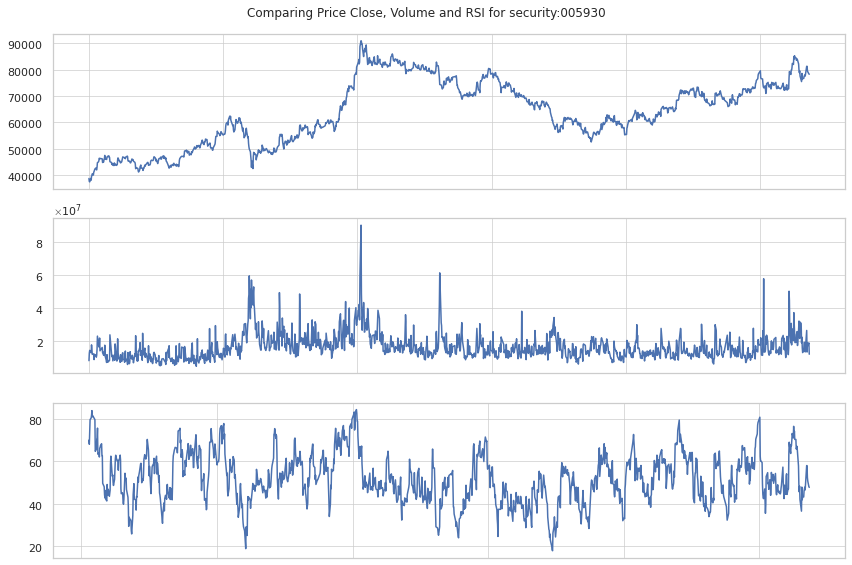

In [136]:
sns.set_style("whitegrid")
df['RSIcat'] = list(map(rsi_class, df['RSI']))

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (12,8))
fig.subplots_adjust(hspace=0.5)
ax1.plot(df.index, df['Close']);
labels = [item.get_text() for item in ax1.get_xticklabels()]
ax1.set_xticklabels(labels)
ax2.plot(df.index, df['Volume']);
labels = [item.get_text() for item in ax2.get_xticklabels()]
ax2.set_xticklabels(labels)
ax3.plot(df.index, df['RSI']);
labels = [item.get_text() for item in ax3.get_xticklabels()]
ax3.set_xticklabels(labels)

plt.suptitle(f"Comparing Price Close, Volume and RSI for security:{Ticker}")
plt.tight_layout()

In [137]:
df.dropna(inplace=True)

MSIcat 열을 만들면서 14개의 일자가 밀렸기 때문에, 앞 14개는 drop 처리해준다

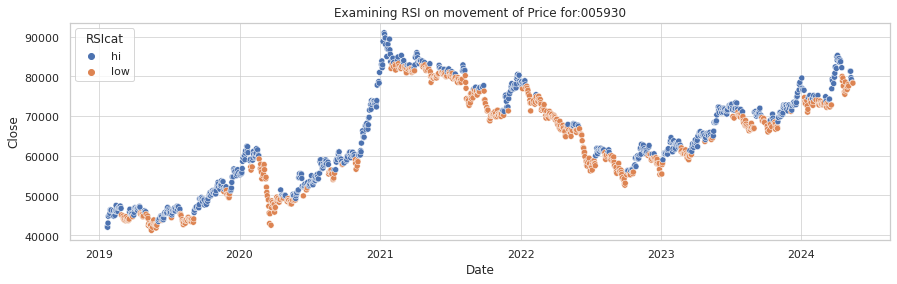

In [138]:
sns.set(rc={'figure.figsize':(14.7,4)})
sns.set_style("whitegrid")

df['RSIcat'] = list(map(rsi_class, df['RSI']))
plt.title(f"Examining RSI on movement of Price for:{Ticker}")
ax = sns.scatterplot(x = df.index, y = df["Close"], hue = df["RSIcat"]);
plt.show()

- Low(주황)일 때는 사지 않고, Med 이상(파랑) 일 때만 매입하는 전략
- Med 이상이라는 말은 매수세가 강하게 들어오고 있다는 신호이므로, 매입 신호로 많이 쓰인다
- [출처](https://www.kaggle.com/code/riteshsinha/useful-features-in-predicting-stock-prices)

In [139]:
df.describe()

,Open,High,Low,Close,Volume,Change,RSI,MFI
count,"1,309.00","1,309.00","1,309.00","1,309.00","1,309.00","1,309.00","1,309.00","1,309.00"
mean,"64,092.90","64,646.94","63,495.23","64,047.78","16,270,276.15",0.00,52.00,49.37
std,"12,100.76","12,159.37","12,019.37","12,068.38","8,000,885.95",0.02,11.69,15.09
min,"41,300.00","42,050.00","40,850.00","41,200.00","4,406,531.00",-0.06,17.86,11.08
25%,"55,000.00","55,600.00","54,400.00","55,000.00","11,155,697.00",-0.01,43.84,39.45
50%,"64,000.00","64,600.00","63,600.00","64,100.00","14,337,913.00",0.00,51.36,49.62
75%,"73,400.00","74,000.00","72,800.00","73,300.00","19,023,323.00",0.01,60.38,60.15
max,"90,300.00","96,800.00","89,500.00","91,000.00","90,306,177.00",0.10,84.50,89.51


# MFI로 매수/매도 신호 파악하기
- MFI가 20선을 상향돌파하면 매수, 80선을 하향돌파하면 매도하는 전략을 사용할 수 있다

In [152]:
def mfi_class(x):
    if x > 20 and x < 80:
        return "Buy"
    else:
        return "Sell"


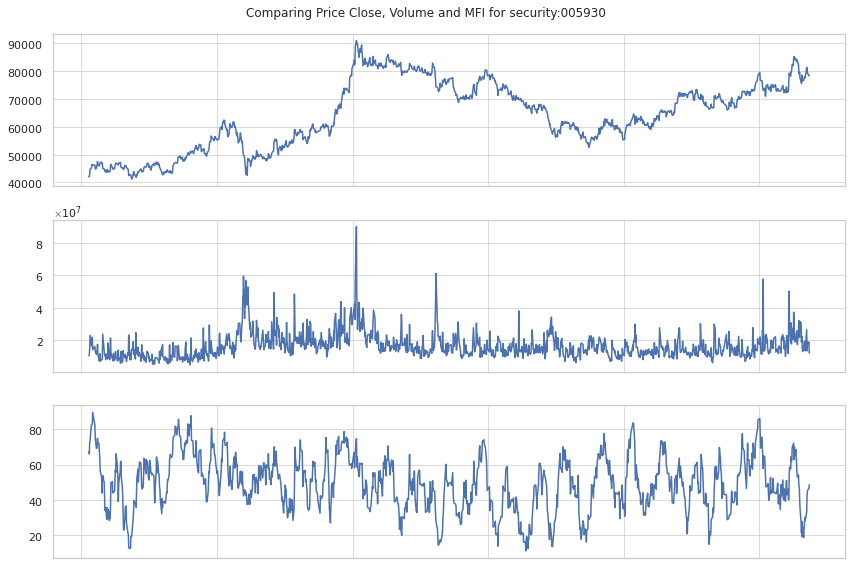

In [153]:
sns.set_style("whitegrid")
df['MFIcat'] = list(map(mfi_class, df['MFI']))

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (12,8))
fig.subplots_adjust(hspace=0.5)
ax1.plot(df.index, df['Close']);
labels = [item.get_text() for item in ax1.get_xticklabels()]
ax1.set_xticklabels(labels)
ax2.plot(df.index, df['Volume']);
labels = [item.get_text() for item in ax2.get_xticklabels()]
ax2.set_xticklabels(labels)
ax3.plot(df.index, df['MFI']);
labels = [item.get_text() for item in ax3.get_xticklabels()]
ax3.set_xticklabels(labels)

plt.suptitle(f"Comparing Price Close, Volume and MFI for security:{Ticker}")
plt.tight_layout()

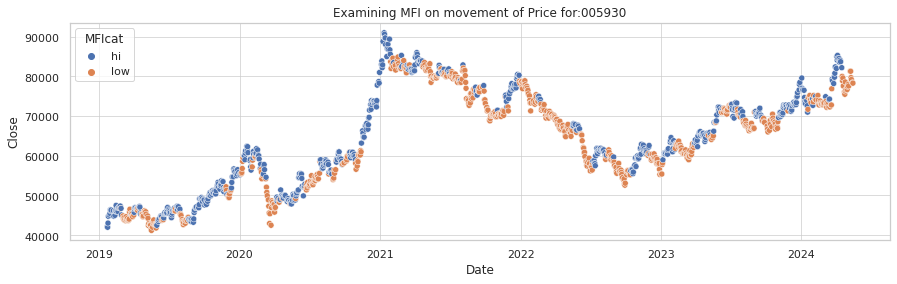

In [154]:
sns.set(rc={'figure.figsize':(14.7,4)})
sns.set_style("whitegrid")

df['MFIcat'] = list(map(rsi_class, df['MFI']))
plt.title(f"Examining MFI on movement of Price for:{Ticker}")
ax = sns.scatterplot(x = df.index, y = df["Close"], hue = df["MFIcat"]);
plt.show()